# Pre-Processing

This notebook contained data-preprocessing steps to transform the raw dataset.

### Load data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
file_path = "..\data\ALGOUSDT.csv"
df = pd.read_csv(file_path, sep="|", header=None)
print(df.shape)

(2991782, 10)


In [45]:
# set column names
df.columns = ["timestamp", "open", "high", "low", "close", "volume", "Taker Buy Quote Asset Volume", 
              "Taker Buy Base Asset Volume", "Quote Asset Volume", "Number of trades"]

# convert unix timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', origin='unix')

# set timestamp as index
df = df.set_index("timestamp")

# sort by index
df = df.sort_index()

# display the first five rows
df.head(2)

,open,high,low,close,volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,Quote Asset Volume,Number of trades
timestamp,,,,,,,,,
2019-06-22 00:00:00,3.40,3.440,2.989,3.150,196437.510,364193.883,113795.25,626516.851,796
2019-06-22 00:01:00,3.15,3.151,3.019,3.039,157708.607,229296.225,73837.53,487567.859,595


In [46]:
df.tail(2)

,open,high,low,close,volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,Quote Asset Volume,Number of trades
timestamp,,,,,,,,,
2025-03-01 18:09:00,0.2362,0.2364,0.2362,0.2363,8497.0,1312.0,5552.0,2007.0,43
2025-03-01 18:10:00,0.2363,0.2364,0.2362,0.2364,6454.0,1096.0,4638.0,1525.0,42


The dataset contains 1 minute OHLCV data from 22 Jun 2019 to 01 Mar 2025 (2,991,782 records)

In [47]:
def gen_plot(df, title=None):
    plt.figure(figsize=(12, 3))
    plt.plot(df)
    plt.title(title)
    plt.grid(alpha=0.3)

### Check Completeness

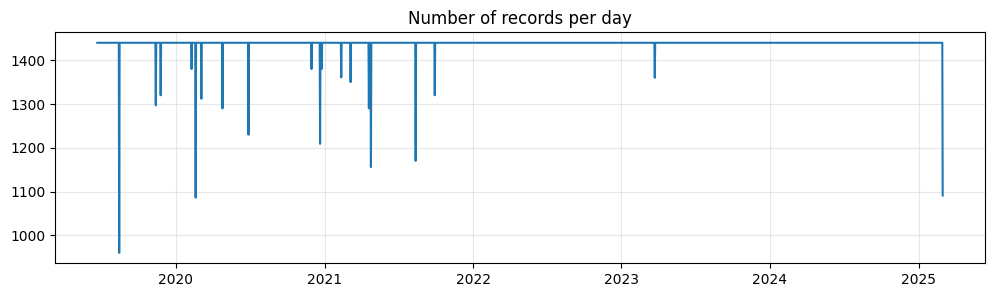

In [48]:
# Calculate number of records per day
count = df['open'].resample('1D').apply(lambda x: x.count())

# Plot the number of records per day
gen_plot(count, "Number of records per day")

In [49]:
# Find days with incomplete records
incomplete_index = count[count != 1440].index
print(incomplete_index, len(incomplete_index))

DatetimeIndex(['2019-08-15', '2019-11-13', '2019-11-25', '2020-02-09',
               '2020-02-19', '2020-03-04', '2020-04-25', '2020-06-28',
               '2020-11-30', '2020-12-21', '2020-12-25', '2021-02-11',
               '2021-03-06', '2021-04-20', '2021-04-25', '2021-08-13',
               '2021-09-29', '2023-03-24', '2025-03-01'],
              dtype='datetime64[ns]', name='timestamp', freq=None) 19


In [50]:
# Drop 2025-03-01 data
df = df[:'2025-02-28']

### Return

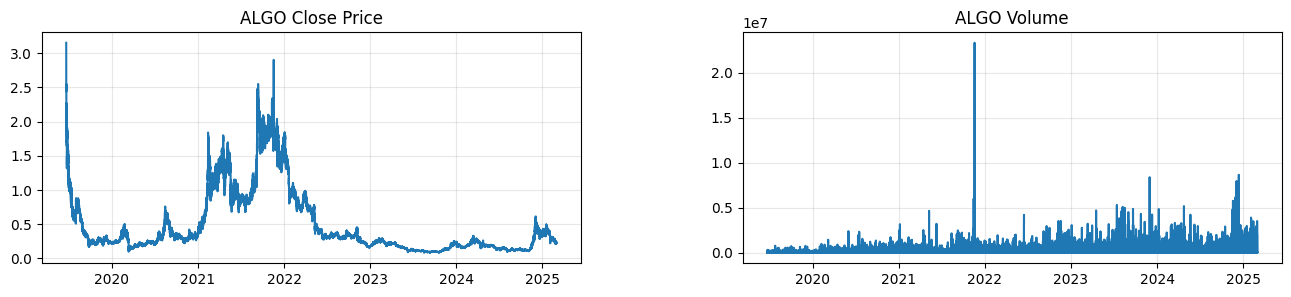

In [51]:
# Plot daily close price and volume
fig, ax = plt.subplots(1, 2, figsize=(16, 3))
plt.subplots_adjust(wspace=0.3)
ax[0].plot(df['close'])
ax[0].set_title('ALGO Close Price')
ax[0].grid(alpha=0.3)
ax[1].plot(df['volume'])
ax[1].set_title('ALGO Volume')
ax[1].grid(alpha=0.3)
plt.savefig('../fig/Algorand Price and Volume.png')

In [52]:
# find the date where the log return is maximum
max_price_date = df['close'].idxmax()
print(max_price_date)

# find the date where the log return is maximum between 2021 and 2022
df_2021_2022 = df['2021-01-01':'2022-12-31']    
max_price_date_2021_2022 = df_2021_2022['close'].idxmax()
print(max_price_date_2021_2022)

2019-06-22 00:00:00
2021-11-18 04:37:00


### Create Log Return

For $ t = 1, \dots, 2079 $:

$\quad$ For $ n = 1 $:

$$ r_{t,1} = log(p_{t,1}) - log(p_{t-1, 1440}) $$

$\quad$ For $ n = 2, 3, \dots, 1440 $:

$$ r_{t,n} = log(p_{t,n}/p_{t, n-1}) = log(p_{t,n}) - log(p_{t, n-1}) $$

where $p_{t,n}$ is the asset close at the nth minute in time $t$. 

Exception: $r_{1, 1}$ is not defined. 

In [53]:
# construct log return
df['return'] = np.log(df['close']).diff()
df.dropna(inplace=True)

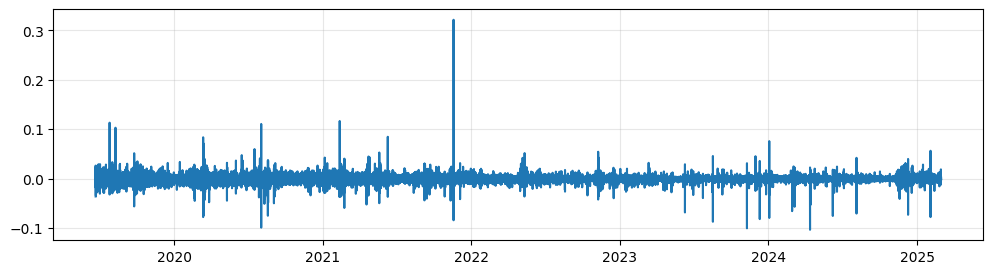

In [54]:
# plot log return
gen_plot(df['return'])

In [55]:
# find the date where the (log) return is maximum
max_return_date = df['return'].idxmax()
print(max_return_date)

2021-11-18 04:25:00


### Resampling to Daily Records

$$ r_t = log(p_t) - log(p_{t-1}) $$

$$ RV_t = \sum_{n=1}^{1440} {r_{t, n}^2} $$

$$ lnRV_t = log(\sum_{n=1}^{1440} {r_{t, n}^2}) $$

In [56]:
# resample to construct a new dataframe for daily OHLC records
df_daily = df.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 
                                           'close': 'last', 'volume': 'sum'})

# construct daily (log) return
df_daily['return'] = np.log(df_daily['close']).diff()
df_daily.dropna(inplace=True)

# construct daily realised volatility
df_daily['RV'] = df['return'].resample('1D').apply(lambda x: np.sum(x**2))

# log transform daily realised volatility
df_daily['lnRV'] = np.log(df_daily['RV'])

### Plots

#### Daily Values

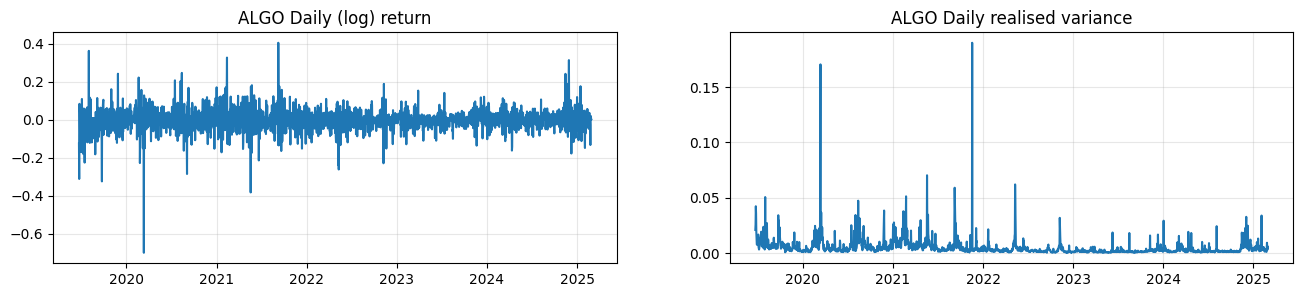

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(16, 3))
ax[0].plot(df_daily['return'])
ax[0].set_title('ALGO Daily (log) return')
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)
ax[1].plot(df_daily['RV'])
ax[1].set_title('ALGO Daily realised variance')
plt.savefig('../fig/ALGO daily log return and RV series.png')

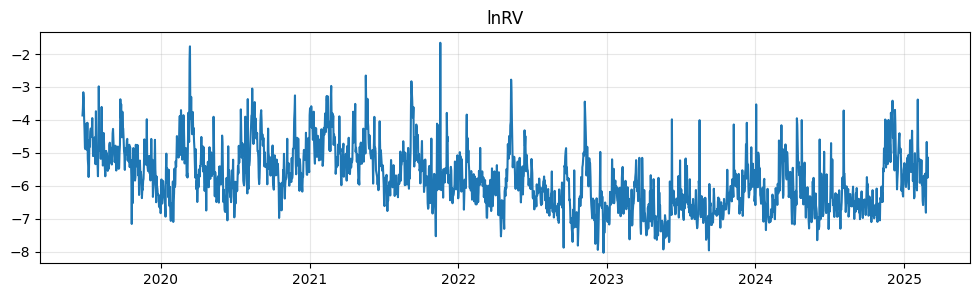

In [58]:
gen_plot(df_daily['lnRV'], "lnRV")

### Summary Statistics

In [59]:
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample.

The Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. The test statistic is always nonnegative. If it is far from zero, it signals the data do not have a normal distribution.

In [60]:
df_daily.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return', 'RV', 'lnRV'], dtype='object')

In [61]:
summary_table = pd.DataFrame(index=['mean', 'median', 'std', 'min', 'max', 'skewness', 'kurtosis', 
                                    'ADF', 'ADF p-value', 'JB statistic', 'JB p-value'])

for c in df_daily.columns[:7]:
    summary_table[c] = [df_daily[c].mean(), df_daily[c].median(), df_daily[c].std(),
                        df_daily[c].min(), df_daily[c].max(), df_daily[c].skew(),
                        df_daily[c].kurtosis(), adfuller(df_daily[c])[0], adfuller(df_daily[c])[1], 
                        stats.jarque_bera(df_daily[c]).statistic, stats.jarque_bera(df_daily[c]).pvalue]
print(summary_table.T)
summary_table.T.to_csv('../data/summary_table.csv')

                mean        median           std           min           max  \
open    4.812663e-01  2.851000e-01  4.633789e-01  8.860000e-02  2.378000e+00   
high    5.072574e-01  2.993500e-01  4.943220e-01  9.040000e-02  2.990000e+00   
low     4.549249e-01  2.682000e-01  4.341852e-01  8.200000e-02  2.031800e+00   
close   4.803363e-01  2.848000e-01  4.619221e-01  8.870000e-02  2.379300e+00   
volume  4.733598e+07  3.375083e+07  5.676236e+07  1.453340e+06  7.353603e+08   
return -1.068681e-03  9.827424e-04  6.137263e-02 -7.005656e-01  4.055695e-01   
RV      5.113411e-03  2.886783e-03  8.532440e-03  3.252749e-04  1.900182e-01   

         skewness    kurtosis        ADF   ADF p-value  JB statistic  \
open     1.715691    2.122797  -2.080380  2.524766e-01  1.405230e+03   
high     1.748793    2.368912  -1.871810  3.454363e-01  1.540024e+03   
low      1.714494    2.106639  -1.731687  4.148645e-01  1.397929e+03   
close    1.714148    2.113807  -2.041065  2.688626e-01  1.400122e+03   

### Histogram and QQ-plot of daily log return series

In [62]:
import statsmodels.api as sm

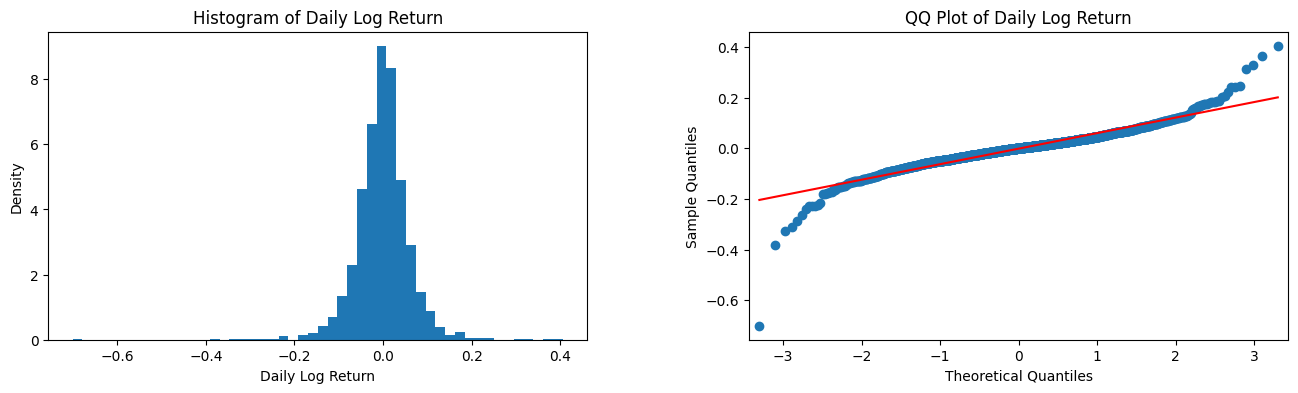

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plt.subplots_adjust(wspace=0.3)
ax[0].hist(df_daily['return'], bins=50, density=True)
ax[0].set_xlabel('Daily Log Return')
ax[0].set_ylabel('Density')
ax[0].set_title('Histogram of Daily Log Return')
sm.qqplot(df_daily['return'], line ='s', ax=ax[1])
plt.title('QQ Plot of Daily Log Return')
plt.savefig('../fig/Histograms and QQ plots of ALGO daily log return series.png')

### Histogram and QQ-plot of daily lnRV

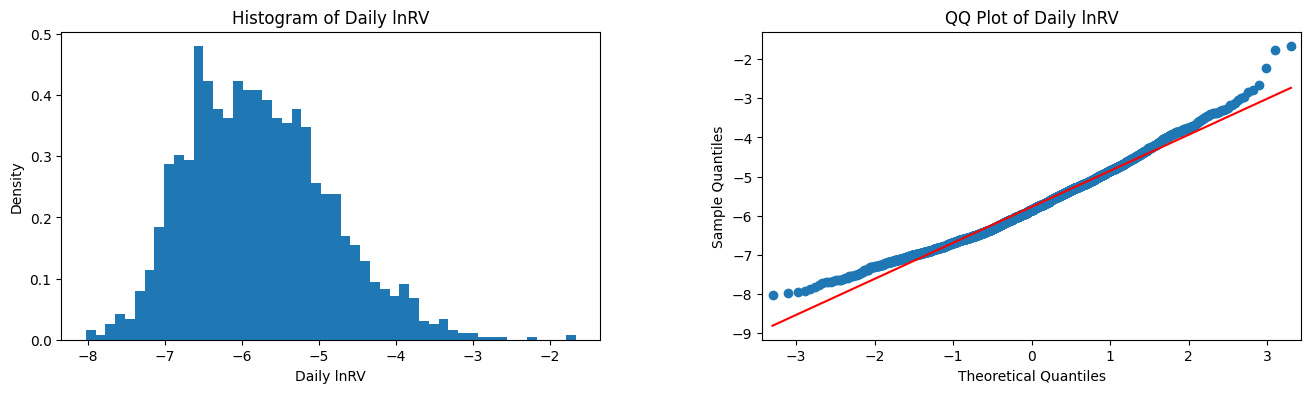

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plt.subplots_adjust(wspace=0.3)
ax[0].hist(df_daily['lnRV'], bins=50, density=True)
ax[0].set_xlabel('Daily lnRV')
ax[0].set_ylabel('Density')
ax[0].set_title('Histogram of Daily lnRV')
sm.qqplot(df_daily['lnRV'], line ='s', ax=ax[1])
plt.title('QQ Plot of Daily lnRV')
plt.savefig('../fig/Histograms and QQ plots of ALGO daily lnRV series.png')

### Save pre-processed data

In [65]:
df_daily.to_csv('..\data\ALGO_daily.csv')